# Self-Driving Car Engineer Nanodegree

## Computer Vision

### Project: Vehicle Detection Project

The code in this notebook implements the steps necessary to detect the vehicles on the road. The comments explain the individual steps.

The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.

* Normalize the features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.

In [1]:
# Import necessary python libs

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
import pickle
from collections import deque
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline  

### Function to return HOG features (and visualization)

The function get_hog_features is a copy of the course material. It extracts hog features by calling the hog function from scikit learn with the given parameters. The Histogram of Oriented Gradient (HOG) feature descriptor is popular for object detection.

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Function to compute binned features (resize and flatten)

The function bin_spatial computes for each color a flattened vector and stacks them horizontally

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

### Function to extract color histogram features

The function color_hist compuates histograms for each color channel and concatenates the result

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Function to extract features (color histogram and/or hog features are choosable)

The function extract_features is a copy of the course material. It first converts in the colorspace which was given by argument. And then makes use of the functions above. It calculates spatial features by calling bin_spatial, histogram features by calling color_hist and finally hog features by calling get_hog_features on either a specific or all three channels. It operates on a list of files and returns a list of feature vectors.

In [5]:
def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=16, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features) 
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Helper function to convert image to specific color space

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

### Function that can extract features using hog sub-sampling and make predictions

The function find_cars is a copy of the course material. It

* Converts the image to a specific color space
* Scales the image (Because cars in the far appear smaller than being close)
* Slide a window horizontally from ystart to ymax over the image
* cells_per_step means there is an overlay of 75% of the windows
* The part of the image which is currently regarded is the base for calculating hog, spatial and histogram feature vector which is then fed into a linear SVC
* The result is a list of bounding boxes plus a window where the classification matches are depicted

In [7]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw=False, demo_all_windows=False):
    
    window_list = []
    
    if draw == True:
        draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if (test_prediction == 1) or (demo_all_windows):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
                if draw == True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    if draw == False:
        return window_list
    else:
        return window_list, draw_img

### Helper function to draw bounding boxes

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Applying functions defined above

## Extract HOG features from a single image

In [9]:
# Here I am extracting HOG features on both a car and a non car image

car_example = mpimg.imread('training/vehicles/GTI_Far/image0000.png') # scaled 0...1
example_gray_car = cv2.cvtColor(car_example, cv2.COLOR_RGB2GRAY) # scaled 0...255

non_car_example = mpimg.imread('training/non-vehicles/GTI/image49.png') # scaled 0...1
example_gray_non_car = cv2.cvtColor(non_car_example, cv2.COLOR_RGB2GRAY) # scaled 0...255

# Parameters of HOG descriptor
orientations = 9
pixels_per_cell = 8
cells_per_block = 2
visualization = True
feature_vector = True

features_car, hog_image_car = get_hog_features(example_gray_car, orientations, pixels_per_cell, cells_per_block, 
                        visualization, feature_vector)

features_non_car, hog_image_non_car = get_hog_features(example_gray_non_car, orientations, pixels_per_cell, cells_per_block, 
                        visualization, feature_vector)

###  Visualization

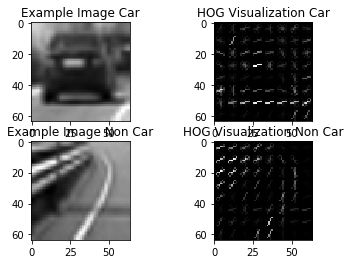

In [10]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = (20,20)

plt.subplot(221)
plt.imshow(example_gray_car, cmap='gray')
plt.title('Example Image Car')

plt.subplot(222)
plt.imshow(hog_image_car, cmap='gray')
plt.title('HOG Visualization Car')

plt.subplot(223)
plt.imshow(example_gray_non_car, cmap='gray')
plt.title('Example Image Non Car')

plt.subplot(224)
plt.imshow(hog_image_non_car, cmap='gray')
_ =plt.title('HOG Visualization Non Car')

plt.imsave('output_images/example_gray_car.png', example_gray_car)
plt.imsave('output_images/hog_image_car.png', hog_image_car)
plt.imsave('output_images/example_gray_non_car.png', example_gray_non_car)
plt.imsave('output_images/hog_image_non_car.png', hog_image_non_car)

HOG - short for Histogram of Oriented Gradients - is a feature descriptor.
It has the following degrees of freedom for tweaking

* Number of orientation bins - orientations
* Size (in pixels) of a cell - pixels_per_cell
* Number of cells in each block - cells_per_block
* Block normalization method - default to L2-Hys

In the image above it is clearly seen that the car image and the non car image are easily distinguishably and therefore a classifier can work based on that feature

## Training a classifier

### Read trainig data

In [11]:
images = glob.glob('training/**/*.png', recursive=True)

cars = []
notcars = []

# All non-vehicle images have the substring 'non-vehicles' 
# in the filename -> distinguish by name
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

### Train a SVM (Support Vector Machine) or SVC (Support Vector Classifier)

The code was taken from the course material

Here a SVC is trained. First the features needs to be extracted as shown above. Then a decision has to be made on the hypter parameters. For example

* Which colorspace? -> I chose YCrCb
* How many orientations for HOG -> I chose 9
* How many pixels per cell? -> I chose 8
* How many cells per block? -> I chose 2
* Specific channel for HOG or all channels? -> I chose ALL

When the feature vector is extracted it needs to be normalized by the scaler and the sclaling applied to the feature vectors.

After that the features vectors needs be shuffled and split into training and test set.

Finally a linear SVC is trained with the following parameters
* C=1.0
* class_weight=None
* dual=True
* fit_intercept=True,
* intercept_scaling=1
* loss='squared_hinge'
* max_iter=1000,
* multi_class='ovr'
* penalty='l2'
* random_state=None
* tol=0.0001,
* verbose=0

(I store the svc in pickle format to avoid trainig again when I want to restart the Kernel and rerun all)

In [12]:
# Parameters of color histogram and hog descriptor

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


spatialSize=(32, 32)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
hist_bins = 32

t=time.time()

car_features = extract_features(cars, color_space=colorspace, spatial_size = spatialSize, hist_bins = hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size = spatialSize, hist_bins = hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = scaler.fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# remove ''' ''' when re-training. Otherwise use pickle data


# Use a linear SVC 

svc= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


pickle.dump(svc, open( "svc.p", "wb" ))


76.74 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
0.00145 Seconds to predict 10 labels with SVC


In [13]:
svc = pickle.load( open( "svc.p", "rb" ) )

## Defining a list of search windows

In [90]:
all_search_windows = []


ystart = 400
ystop = 656
scale = 1.5

window = [ystart, ystop, scale]
all_search_windows.append(window)

ystart = 400
ystop = 528
scale = 1.5

window = [ystart, ystop, scale]
all_search_windows.append(window)

'''
ystart = 400
ystop = 464
scale = 1.0

window = [ystart, ystop, scale]
all_search_windows.append(window)
                       
ystart = 416
ystop = 480
scale = 1.0

'''

window = [ystart, ystop, scale]
all_search_windows.append(window)
                       
ystart = 400
ystop = 496
scale = 1.0

window = [ystart, ystop, scale]
all_search_windows.append(window)
                  
ystart = 432
ystop = 528
scale = 1

window = [ystart, ystop, scale]
all_search_windows.append(window)
                       
ystart = 400
ystop = 528
scale = 1.5

window = [ystart, ystop, scale]
all_search_windows.append(window)
                  
ystart = 432
ystop = 560
scale = 1.5

window = [ystart, ystop, scale]
all_search_windows.append(window)
                       
ystart = 400
ystop = 656
scale = 3.0

window = [ystart, ystop, scale]
all_search_windows.append(window)
                       
ystart = 464
ystop = 720
scale = 3

window = [ystart, ystop, scale]
all_search_windows.append(window)

### Using sliding windows which will be search finally

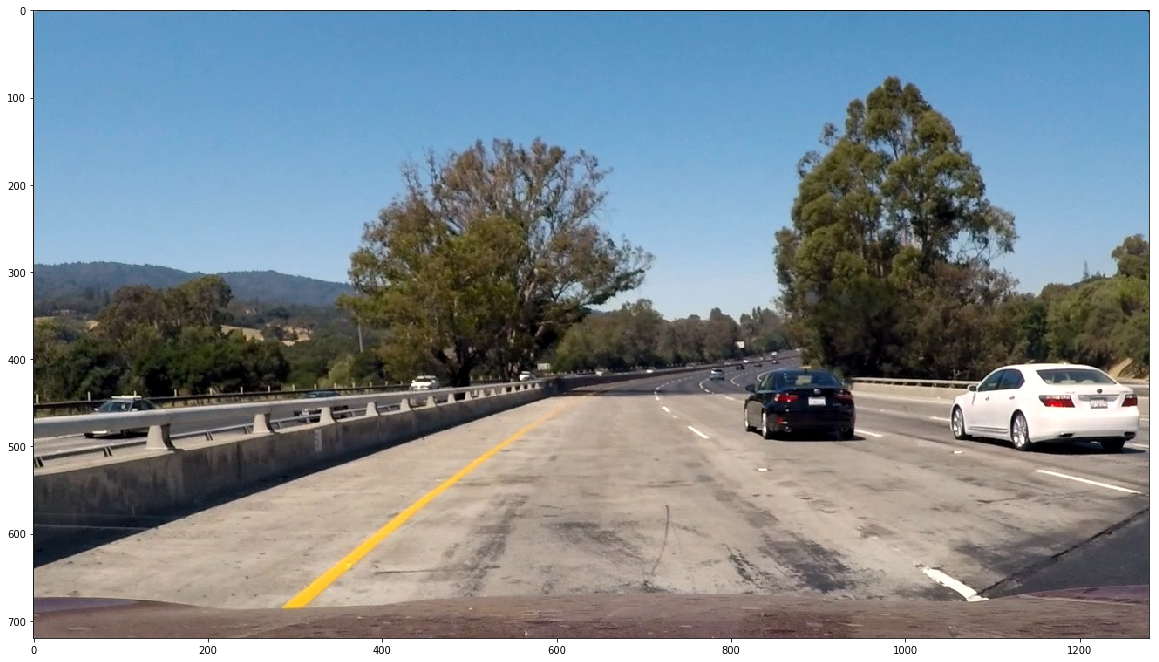

In [15]:
# Load an example image (scaled 0...1)
example = mpimg.imread('test_images/test1.jpg')

result_boxes = []


for search_window in all_search_windows:
    ystart = search_window[0]
    ystop = search_window[1]
    scale = search_window[2]
    result_boxes.append(find_cars(example, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatialSize, hist_bins, draw=False, demo_all_windows=True))

   
result = draw_boxes(example, result_boxes[0])
plt.imshow(result)


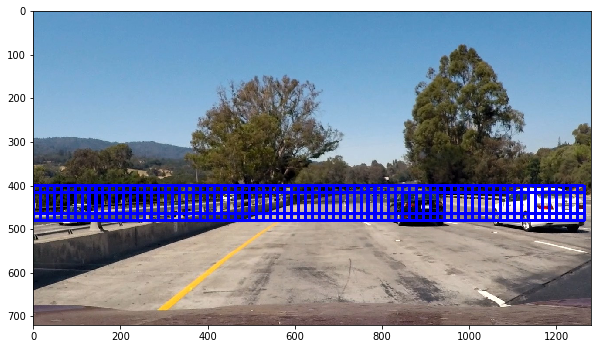

In [89]:
# Load an example image (scaled 0...1)
example = mpimg.imread('test_images/test1.jpg')

result_boxes = []


ystart = 400
ystop = 496
scale = 1





result_boxes = find_cars(example, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatialSize, hist_bins, draw=False, demo_all_windows=True)

result = draw_boxes(example, result_boxes)
plt.imshow(result)

### Apply SVM on an image via sliding window (only subset)

The code below shows extracting bounding boxes for cars by calling the find_cars function

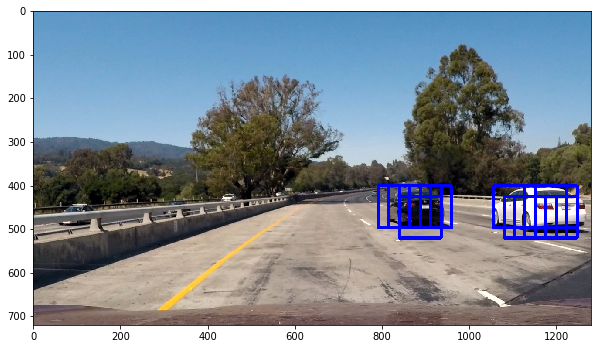

In [26]:
# Load an example image (scaled 0...1)
example = mpimg.imread('test_images/test1.jpg')

# Define search window and scaling
ystart = 400
ystop = 656
scale = 1.5
# svc was already trained above

windows_list, out_img = find_cars(example, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatialSize, hist_bins, draw=True)

_ = plt.imshow(out_img)

## Dealing with multiple detections

In the image above it is clearly seen that there are multiple detections of cars with several bounding boxes. One approach - which was presented in the course is introducing heat maps. 

Heat is added where bounding boxes are and finally the center with the most heat is selected

### Helper function add_heat

The function below adds heat of 1 wherever a bounding box is present

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes   
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

### Helper function apply_threshold

The function thresholds a heat map by zeroing out pixels which hold less then threshold heat

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### Helper function heat_filter

The function below takes three heat images (the current, the one one time step before and the one two time steps before and weights them)

Let's assume there was a single frame for a potential vehicle and the area the potential vehicle appears was empty before. In time step one the heat map has value 0.5 and it will be filtered out. If is present in the next frame it has the value 1 ( 1x0.5 + 0.5x1 + 0x1 ). And in the next frame 1.5 ( 1x0.5 + 0.5x1 + 0.5x1 ).

* Meaning consecuteive detections will have a value of at least 1.5.
* 2 of 3 detection will lead to a value of max 1 (if only one window in the area)
* 1 of 3 detection will lead to a value 0f max 0.5 (if only one window in the area)

So a reasonable threshold to apply would be 1 to require at least 3 consecutive detections. (apply_threshold check equals or less "<=")

Note: This applies for single bounding box. I expect disturbances to be rather single bounding boxes than several I expect in the area of real occurances of vehicles.

In [20]:
def heat_filter(heat, heat_k1, heat_k2, fac_new=0.5, fac_k1=1, fac_k2=1):
    result = np.multiply(heat,fac_new) + np.multiply(heat_k1, fac_k1) + np.multiply(heat_k2, fac_k2)
    return result

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    final_bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        final_bboxes.append(bbox)
    # Return the image
    return final_bboxes, img

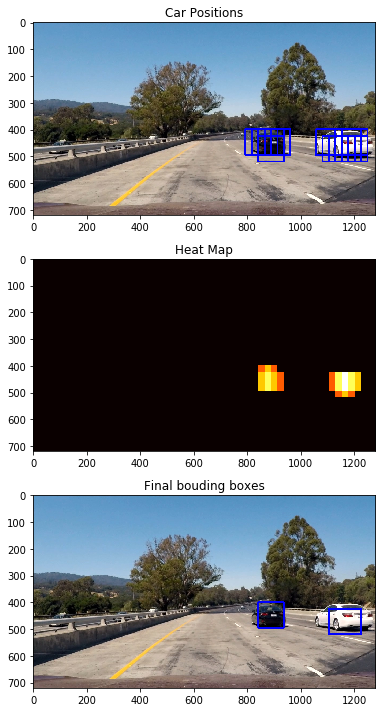

In [22]:
# Add heat to each box in box list
heat = np.zeros_like(example[:,:,0]).astype(np.float)

heat = add_heat(heat,windows_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
final_bboxes, draw_img = draw_labeled_bboxes(np.copy(example), labels)

#result = draw_boxes(example, final_bboxes)

plt.rcParams['figure.figsize'] = (10,10)
fig = plt.figure()
plt.subplot(311)
plt.imshow(out_img)
plt.title('Car Positions')
plt.subplot(312)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(313)
plt.imshow(draw_img)
plt.title('Final bouding boxes')
fig.tight_layout()


# Processing function

The function process_image just makes use of all the function described above.

* First it call find_cars for several window sizes and scalings
* Then a heat map is generated and static values for historic values (k1 and k2 are stored)
* Heatmap threshold is applied
* Result is returned (Image with bounding boxes)

In [67]:
# all meta data (arguemts of find_cars function) is 
# used globally so it is harmonized to the training

def process_image(input):
    global svc
    global X_scaler

    global orient
    global pix_per_cell
    global cell_per_block
    global spatialSize
    global hist_bins
    
    global heat_k1
    global heat_k2

    
    windows_list = []
    
    for search_window in all_search_windows:
        ystart = search_window[0]
        ystop = search_window[1]
        scale = search_window[2]
        
               
        windows_list.append(find_cars(input, ystart, ystop, scale, svc, 
                    X_scaler, orient, pix_per_cell, 
                    cell_per_block, spatialSize, hist_bins))
        
    
    clean_list = []
    
    for element in windows_list:
        if element != []:
            for single_window in element:
                clean_list.append(single_window)
                
    
    # clean up empty elements or elements which are a list itself (why is that btw?)
    # windows_list = [item for item in windows_list if ((item != []) and (type(item) is not list))]

        
    # Add heat to each box in box list
    heat = np.zeros_like(input[:,:,0]).astype(np.float)
    heat = add_heat(heat,clean_list)
    
    filtered_heat = heat_filter(heat, process_image.heat_k1, process_image.heat_k2, 0.5, 1, 1)
    
    process_image.heat_k2 = process_image.heat_k1 
    process_image.heat_k1 = heat
    
    # Apply threshold to help remove false positives
    filtered_heat = apply_threshold(filtered_heat,1.0)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(filtered_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final_bboxes, draw_img = draw_labeled_bboxes(np.copy(input), labels)

    result = draw_boxes(input, final_bboxes)
    
    return result

process_image.heat_k1 = np.zeros_like(example[:,:,0]).astype(np.float)
process_image.heat_k2 = np.zeros_like(example[:,:,0]).astype(np.float)

# Apply processing chain on a video file

In [ ]:
video_output = "output_images/projct_output.mp4"
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)

%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/projct_output.mp4
[MoviePy] Writing video output_images/projct_output.mp4



 12%|█▏        | 152/1261 [02:56<21:30,  1.16s/it]


 24%|██▍       | 303/1261 [05:53<18:43,  1.17s/it]


 36%|███▌      | 454/1261 [08:49<15:40,  1.17s/it]


 43%|████▎     | 543/1261 [10:34<14:02,  1.17s/it]